In [1]:
"""
continuacion desde VerMarquetBalnce-sql-2.5.ipynb

mejora apertura de operaciones incorporando criterio TREND UP para subidas lentas
tambien se desaCtiban los siguientes metodos de apertura para mejora del profit:
    "MB UP 1" : OpeningTypeID = 1
    "MB UP 3" : OpeningTypeID = 3
    "CH UP"   : OpeningTypeID = 5

prendiente:
    encapsular los metodos de grafico en una clase independiente
    encasular los metodos de bbdd en una clase independiente
    implementar ploteo de operaciones sin calcular entradas salidas
    encapsular calculo de entrada salida en una clase independiente que corra periodicamante online
    crear script mail con multitread que ejecute lectura de dados y calculo de operaciones online 
"""

# imports
import numpy as np
import krakenex as k
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import datetime
from pathlib import Path
import sys
from datetime import datetime, timedelta
from matplotlib import dates 
import IPython.core.debugger
dbg = IPython.core.debugger.Pdb()
#dbg.set_trace() #colocar dondo punto interrupcion
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

start = time.time()


In [2]:
#set SQL BBDD
from sqlalchemy import create_engine, MetaData, Table, Column, DateTime, Float, String,Integer

dbInstance = 'sqlite:///krakenTeader.db'
dbBalanceHistoryTable = 'BalanceHistory'
dbTradesHistoryTable = 'TradesHistory'
dbMyTradesTable = 'MyTrades'
dbTradesCondensationTable = 'TradesCondensation'

engine = create_engine(dbInstance)

if not engine.dialect.has_table(engine, dbMyTradesTable):  # If table don't exist, Create.
    metadata = MetaData(engine)
    
    # Create a table with the appropriate Columns
    Table(dbMyTradesTable, metadata,
             Column('id', Integer, nullable=True), 
             Column('openTime', DateTime, nullable=True), 
             Column('closeTime', DateTime, nullable=True), 
             Column('tradeDescription', String, nullable=True), 
             
             Column('OpeningTypeID', Integer, nullable=True), 
             Column('ClosingTypeID', Integer, nullable=True), 
          
             Column('openingCH', Float, nullable=True), 
             Column('baseCH', Float, nullable=True), 
             Column('targetCH', Float, nullable=True), 
             Column('stopLoseCH', Float, nullable=True), 
             Column('TotalLoseCH', Float, nullable=True), 
             Column('closingCH', Float, nullable=True), 
             Column('deltaCH', Float, nullable=True), 
             
             Column('openingP', Float, nullable=True), 
             Column('baseP', Float, nullable=True), 
             Column('targetP', Float, nullable=True), 
             Column('stopLoseP', Float, nullable=True), 
             Column('TotalLoseP', Float, nullable=True), 
             Column('closingP', Float, nullable=True), 
             Column('deltaP', Float, nullable=True), 
          
             Column('Profit', Float, nullable=True),
             Column('Profit_Gastos', Float, nullable=True))
    # Implement the creation
    metadata.create_all() 
    
if not engine.dialect.has_table(engine, dbTradesCondensationTable):  # If table don't exist, Create.
    metadata = MetaData(engine)
    
    # Create a table with the appropriate Columns
    Table(dbTradesCondensationTable, metadata,
             Column('time', DateTime, nullable=True), 
             Column('price', Float, nullable=True), 
             Column('countb', Float, nullable=True), 
             Column('volb', Float, nullable=True), 
             Column('counts', Float, nullable=True), 
             Column('vols', Float, nullable=True))
    # Implement the creation
    metadata.create_all()

In [3]:

#preparar datos para plotear
BalanceHistory = pd.read_sql(dbBalanceHistoryTable, con=engine)
BalanceHistory = BalanceHistory.set_index(pd.DatetimeIndex(BalanceHistory['Time']))
BalanceHistory.drop('Time', axis=1,inplace=True)

#filtrar periodo de interes
windowTime = (24 * 56) + 12
EndSampleTime = datetime(2017,12,7,12,0,0)
plotmin = True
HoursInterval = 1
if windowTime > 6: plotmin = False
if windowTime > 12: HoursInterval = 2
if windowTime > 24: HoursInterval = 4
if windowTime > 24 * 2: HoursInterval = 8
if windowTime > 24 * 5: HoursInterval = 12
if windowTime > 24 * 10: HoursInterval = 24
if windowTime > 24 * 15: HoursInterval = 48
if windowTime > 24 * 30: HoursInterval = 96

verUltimo=False
startSampleTime = datetime.now() + timedelta(hours=windowTime*-1)
if verUltimo:
    BalanceHistory = BalanceHistory[BalanceHistory.index > startSampleTime]
else:
    startSampleTime = EndSampleTime + timedelta(hours=windowTime*-1)
    BalanceHistory = BalanceHistory[(BalanceHistory.index >= startSampleTime) & (BalanceHistory.index <= EndSampleTime)]

#combertir el balance a un porcentaje entre -100% y 100%
BalanceHistory['balanceRatio'] = (BalanceHistory['balanceRatio'] - 0.5 )*2*100 

BalanceHistory['volbuy'] = BalanceHistory['volbuy'] / BalanceHistory['close']
BalanceHistory['volsell'] = BalanceHistory['volsell'] / BalanceHistory['close']
BalanceHistory['unbalance'] = BalanceHistory['unbalance'] / BalanceHistory['close']

#calcular %CH, %CH Acum , SMA %CH Acum
BalanceHistory['change'] = BalanceHistory['close'].pct_change(periods=1)*100
#BalanceHistory['cahnge2'] = BalanceHistory['close'] / BalanceHistory['close'].shift(1) -1 #equibalente 
BalanceHistory['cum_change'] = BalanceHistory['change'].cumsum()
BalanceHistory['SMA03_cum_change'] = BalanceHistory['cum_change'].rolling(5).mean()
BalanceHistory['SMA12_cum_change'] = BalanceHistory['cum_change'].rolling(12).mean()

#calcular sma de 3 periodos (suavisar el grafico)
BalanceHistory['EWM_unbalance'] =  BalanceHistory["unbalance"].ewm(span=3).mean()

#calcular la porsiocn negativa (para mostrar en rojo en el grafico)
BalanceHistory['EWM_unbalance_N'] = BalanceHistory['EWM_unbalance']
neg = BalanceHistory['EWM_unbalance_N']
neg[neg >= 0] = np.nan
BalanceHistory['EWM_unbalance_N'] = neg


comCompra = 0.29  
comVenta = 0.19 
spreadEntrada = 0.2 
spreadSalida = 0.2
deltaBaseCH = comCompra + comVenta + spreadEntrada + spreadSalida 

In [4]:
def ReadCondensatedTrades():
    tc = pd.read_sql(dbTradesCondensationTable, con=engine)
    tc.set_index(pd.DatetimeIndex(tc['time']),inplace=True)
    tc.drop('time',inplace=True,axis=1)
    tc = tc[(tc.index >= startSampleTime) & (tc.index <= EndSampleTime)]
    return tc

In [5]:
tradesCondensation = ReadCondensatedTrades()

In [6]:
def plotProfit():
    if len(myTrades) > 0:
        totalCom = len(myTrades) * deltaBaseCH
        totalWin = myTrades.deltaCH.sum()
        finalBalance = totalWin - totalCom
        print('total win: {0}, total commiciones: {1}, Balance Final {2}'.format( totalWin,totalCom,finalBalance))
        if len(myTrades) > 1:
            myTrades['Profit'].plot()   
            myTrades['Profit_Gastos'].plot()

In [7]:
def plotHistory(plotVolume=False, plotTrades=False):
    fig,ax = plt.subplots( sharex=True, figsize=(16,14), nrows=4, ncols=1)

    #plot price
    ax[0].plot_date(BalanceHistory.index, BalanceHistory['close'],'orange',marker='o', markersize=1)
    ax[0].yaxis.grid(True) 
    ax[0].xaxis.grid(True) 
    ax[0].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
    ax[0].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
    if plotmin ==True:
        ax[0].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
        ax[0].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
        ax[0].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

    ax[0].set_title('CLOSE')
    ax[0].legend(loc='best')

    #plot %CH short SMA Large SMA
    ax[1].plot_date(BalanceHistory.index, BalanceHistory['change'],'ro-', markersize=1)
    ax[1].plot_date(BalanceHistory.index, BalanceHistory['cum_change'],'b-')
    ax[1].plot_date(BalanceHistory.index, BalanceHistory['SMA03_cum_change'],'go-', markersize=1,alpha=0.6) #ligthBlue
    ax[1].yaxis.grid(True) 
    ax[1].xaxis.grid(True) 
    ax[1].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
    ax[1].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
    if plotmin ==True:
        ax[1].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
        ax[1].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
        ax[1].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

    ax[1].set_title('% CHANGE - CUMULATIVE CHANGE')
    ax[1].legend(loc='best')
    ax[1].axhline(0,color='g',ls='-')

    #plot  MarquetBalance
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['volbuy'],'g--',alpha=0.5)
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['volsell'],'r--',alpha=0.5) 
    #ax[2].plot_date(BalanceHistory.index, BalanceHistory['unbalance'],'bo-', markersize=3)
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['EWM_unbalance'],'bo-', markersize=1)
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['EWM_unbalance_N'],'ro-', markersize=1)

    ax[2].yaxis.grid(True) 
    ax[2].xaxis.grid(True) 
    ax[2].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
    ax[2].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
    if plotmin ==True:
        ax[2].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
        ax[2].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
        ax[2].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

    ax[2].set_title('volbuy - volsell- unbalance')
    ax[2].legend(loc='best')
    #ax[2].axhline(0,color='g',ls='-')

    # plot volumen
    if plotVolume == True:
        ax[3].plot_date(tradesCondensation.index, tradesCondensation['volb'],'g',marker='o', markersize=3)
        ax[3].plot_date(tradesCondensation.index, tradesCondensation['vols'],'r',marker='o', markersize=3)
        ax[3].yaxis.grid(True) 
        ax[3].xaxis.grid(True) 
        ax[3].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
        ax[3].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
        if plotmin ==True:
            ax[3].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
            ax[3].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
            ax[3].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

        ax[3].set_title('VOLUMEN POR PERIODO')
        ax[3].legend(loc='best')
        ax[3].axhline(0,color='g',ls='-')

    if plotTrades == True:
        cont = 1
        for d in  myTrades.openTime:        
            ax[1].annotate(cont , xy=(d,1))
            ax[0].axvline(d,ymin=-1.2,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
            ax[1].axvline(d,ymin=-1.2,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
            ax[2].axvline(d,ymin=-1.2,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
            ax[3].axvline(d,ymin=0,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
            cont += 1

        for d in myTrades.closeTime:
            ax[0].axvline(d,ymin=-1.2,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
            ax[1].axvline(d,ymin=-1.2,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
            ax[2].axvline(d,ymin=-1.2,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
            ax[3].axvline(d,ymin=0,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)


In [8]:
def plotAllTrades():
    tradesCount = len(myTrades)
    if tradesCount > 0:
        fig, axes = plt.subplots(tradesCount, 2, figsize=(16,tradesCount*5), squeeze=False)
        for i in range(tradesCount):
            n = i+1
            row = axes[i]
            dOpen = myTrades.openTime[n]
            iniPos = BalanceHistory.index.get_loc(dOpen)-5
            iniMoment = BalanceHistory.index[iniPos] 

            sDesc = myTrades.tradeDescription[n]
            
            dClose = myTrades.closeTime[n]
            endPos = BalanceHistory.index.get_loc(dClose)+5
            maxPos  = len(BalanceHistory)
            if endPos >= maxPos:
                endPos = maxPos-1
            
            endMoment = BalanceHistory.index[endPos] 
            
            df =  BalanceHistory[(BalanceHistory.index >= iniMoment) & (BalanceHistory.index <= endMoment)]

            #calcular %CH, %CH Acum , SMA %CH Acum
            #df['change'] = df['close'].pct_change(periods=1)*100
            #df['cum_change'] = df['change'].cumsum()
            #df['SMA03_cum_change'] = df['cum_change'].rolling(3).mean()
            #df['SMA12_cum_change'] = df['cum_change'].rolling(12).mean()
            plotTrade(row, df,dOpen, dClose, sDesc,myTrades.openingCH[n],myTrades.closingCH[n])

        fig.autofmt_xdate() 
        plt.legend() 
        plt.tight_layout() 
        plt.show()
    else:
        print('No trades for plot')

def plotTrade(ax, df, dOpen, dClose, sDesc, openCH,closeCH):
    intervalo = int(HoursInterval/4)
    if intervalo == 0: intervalo = 1
    locator = mdates.HourLocator(interval=intervalo)
    locator.MAXTICKS = 10000

    ax[0].plot_date(df.index, df['volbuy'],'g--',alpha=0.5)
    ax[0].plot_date(df.index, df['volsell'],'r--',alpha=0.5)
    ax[0].plot_date(df.index, df['unbalance'],'bo-', markersize=3)
    #ax[0].plot_date(df.index, df['EWM_unbalance'],'bo-', markersize=3)
    #ax[0].plot_date(df.index, df['EWM_unbalance_N'],'ro-', markersize=3)
    ax[0].axvline(dOpen,ymin=-0,ymax=1,c="#05652F",linewidth=2,zorder=0)
    ax[0].axvline(dClose,ymin=-0,ymax=1,c="#F44C04",linewidth=2,zorder=0)
    ax[0].yaxis.grid(True) 
    ax[0].xaxis.grid(True) 
    ax[0].xaxis.set_major_locator(locator)
    ax[0].xaxis.set_major_formatter(dates.DateFormatter('%d %H'))
    ax[0].yaxis.set_major_locator(mticker.AutoLocator())
    ax[0].xaxis.grid(b=True, which='mayor', color='grey', linestyle='--')
    ax[0].legend(loc='best')
    ax[0].axhline(0,color='g',ls='-')
    ax[0].set_title(sDesc)

    ax[1].plot_date(df.index, df['cum_change']- openCH,'b-')
    ax[1].plot_date(df.index, df['SMA03_cum_change']- openCH,'go-', markersize=2,alpha=0.8)
    ax[1].plot_date(df.index, df['SMA12_cum_change'] - openCH,'o-',color='#3366ff', markersize=2,alpha=0.8) #ligthBlue
    ax[1].axvline(dOpen,ymin=-0,ymax=1,c="#05652F",linewidth=2,zorder=0)
    ax[1].axvline(dClose,ymin=-0,ymax=1,c="#F44C04",linewidth=2,zorder=0)
    
    ax[1].axhline(openCH - openCH,xmin=-0,xmax=1,c="#05652F",linewidth=2,zorder=0)
    ax[1].axhline(closeCH - openCH,xmin=-0,xmax=1,c="#F44C04",linewidth=2,zorder=0)
    
    ax[1].yaxis.grid(True) 
    ax[1].xaxis.grid(True) 
    ax[1].xaxis.set_major_locator(locator)
    ax[1].xaxis.set_major_formatter(dates.DateFormatter('%d %H'))
    ax[1].yaxis.set_major_locator(mticker.AutoLocator())
    ax[1].xaxis.grid(b=True, which='mayor', color='grey', linestyle='--')
    ax[1].legend(loc='best')
    ax[1].axhline(0,color='b',ls='-')

In [9]:
def obtenerMaximo(m,ch):
    if m >= ch: 
        return m
    else:
        return ch 
    
def  acumular(serie,cant,pos):
    su = 0.0
    for i in range(pos,pos - cant - 1,-1):
        su = su + serie[i]
    return su

def restarGastos (s):
    l = []
    for i in range(len(s)):
        l.append((s[i] - (deltaBaseCH*(i+1))))
    return l

def EvaluateTrend(bh,cumCHIncrement):
    try:
        pini = 0 
        pfin = len(bh)-1
        isUpTrend = False
        if ((pfin - pini) >= 60):
            bh['change'] = bh['close'].pct_change(periods=1)*100
            ch = bh['change']
            bh['cum_change'] = bh['change'].cumsum()
            cumch = bh['cum_change']
            if (cumch[pfin] >= cumCHIncrement):
                isUpTrend = True
    except:
        dbg.set_trace()
        raise
    return isUpTrend
    
def OpenerCloserEvaluator (bh, tc, volPriceOpen = 40000, chOpen = 0.5, mbOpen = 0.5, deltaCHObjetivo = 5, chClose = 1, deltaTotalLoseCH = 0.5, waitPeriods = 60, waitFactor = 48, waitPeriodsOutBase = 30, waitFactorOutBase = 6):

    comCompra = 0.29  
    comVenta = 0.19 
    spreadEntrada = 0.2 
    spreadSalida = 0.2
    deltaBaseCH = comCompra + comVenta + spreadEntrada + spreadSalida 

    deltaTargetCH = deltaBaseCH + deltaCHObjetivo
    deltaStopLose = deltaBaseCH - chClose

    s = bh['unbalance']
    sma03 = bh['SMA03_cum_change']
    sma12 = bh['SMA12_cum_change']
    ch = bh['change']
    cumch = bh['cum_change']
    
    volb = tc['volb']
    vols = tc['vols']
    
    openPos = 0
    ClosePos = 0
    isOpen = False
    inBase = False
        
    sOpenCond = ""
    sCloseCond = ""
        
    #valores de cada operacion 
    openingCH = 0.0
    baseCH = 0.0
    targetCH = 0.0
    stopLoseCH = 0.0
    TotalLoseCH = 0.0
    closingCH = 0.0
    deltaCH = 0.0
    idTrade = 0
    openTime = datetime.now()
    closeTime =openTime
    maximo = 0.0
    toleranciaMaximo = 0.6
    maximoTolerado = 0.0
    cantAcumular = 4
    volAcumulado = 0.0
    mbAcumulado = 0.0
    
    OpeningTypeID = 0
    ClosingTypeID = 0
    openingP = 0.0
    baseP = 0.0
    targetP = 0.0
    stopLoseP = 0.0
    TotalLoseP = 0.0
    closingP = 0.0
    deltaP = 0.0
    
    cols = ['id', 'openTime', 'closeTime', 'tradeDescription', 'OpeningTypeID', 'ClosingTypeID', 'openingCH', 'baseCH', 'targetCH', 'stopLoseCH', 'TotalLoseCH', 'closingCH', 'deltaCH', 'openingP', 'baseP', 'targetP', 'stopLoseP', 'TotalLoseP', 'closingP', 'deltaP', 'Profit', 'Profit_Gastos']     
    myTrades = pd.DataFrame(columns=cols)
    
    for i in range(len(s)):
        if i > 12:
            if (isOpen == False):
                if i < len(tc):
                    pini = obtenerMaximo(openPos,ClosePos)
                    pfin = i
                    b = bh[pini:pfin].copy(deep=True)
                    IsUpTrend = EvaluateTrend(b,2.4)
                    if(volb[i] * tc['price'][i] >= volPriceOpen):
                        """
                        if (s[i] > 0) & (s[i-1] < 0):
                            if (sma03[i] > sma03[i-1]+ chOpen):
                                isOpen = True
                                sOpenCond = "MB UP 1"
                                OpeningTypeID = 1
                        elif (s[i] < 0) & (s[i-1] > s[i-2] + mbOpen):
                            isOpen = True
                            sOpenCond = "MB UP 3"
                            OpeningTypeID = 3
                        elif (ch[i] > ch[i-1] + chOpen): 
                            if (sma03[i] > sma03[i-1]+ chOpen):
                                isOpen = True
                                sOpenCond = "CH UP"
                                OpeningTypeID = 5
                        """
                        if (s[i] > 0) & (s[i] > mbOpen):
                            isOpen = True
                            sOpenCond = "MB UP 2"
                            OpeningTypeID = 2
                        elif ((sma03[i-1] < sma12[i-1]) & (sma03[i] > sma12[i])): 
                            if (sma03[i] > sma03[i-1]+ chOpen*1):
                                isOpen = True
                                sOpenCond = "SMA03 UP"
                                OpeningTypeID = 4
                        elif (IsUpTrend == True):
                            isOpen = True
                            sOpenCond = "TREND UP"
                            OpeningTypeID = 6
                if isOpen == True:
                    openPos = i
                    idTrade = idTrade + 1
                    sDesc = '({0}) ─► {1}'.format(idTrade, sOpenCond)
                    inBase = False
                    openTime = s.index[i]
                    openingCH = cumch[i]
                    baseCH = openingCH + deltaBaseCH
                    targetCH = openingCH + deltaTargetCH
                    stopLoseCH = openingCH + deltaStopLose
                    TotalLoseCH = openingCH - deltaTotalLoseCH
                    
                    openingP =  tc['price'][i]
                    baseP = openingP * ((100+deltaBaseCH)/100)
                    targetP = openingP * ((100+deltaTargetCH)/100)
                    stopLoseP = openingP * ((100+deltaStopLose)/100)
                    TotalLoseP = openingP * ((100+deltaTotalLoseCH)/100)
                    
            if (isOpen == True):
                if bh.cum_change[i] >= baseCH: #nivel de perdidas operacionales superado
                    inBase = True
                if inBase == True: 
                    currentCumCH = cumch[i] -  openingCH
                    maximo = obtenerMaximo(maximo,currentCumCH)
                    if (maximo < deltaCHObjetivo):
                        if (maximo >= deltaStopLose) & (maximo < deltaCHObjetivo *0.25):  maximoTolerado = deltaStopLose    
                        elif (maximo >= deltaCHObjetivo *0.25) & (maximo < deltaCHObjetivo *0.5): maximoTolerado = deltaStopLose + 1.2
                        elif (maximo >= deltaCHObjetivo *0.5) & (maximo < deltaCHObjetivo *0.75): maximoTolerado = deltaStopLose + 4.5
                        elif (maximo >= deltaCHObjetivo *0.75) & (maximo < deltaCHObjetivo): maximoTolerado = deltaStopLose + 6.5                    

                    else:
                        if (maximo >= deltaCHObjetivo) & (maximo < deltaCHObjetivo *1.25):        maximoTolerado = deltaCHObjetivo * 0.9
                        elif (maximo >= deltaCHObjetivo *1.25) & (maximo < deltaCHObjetivo *1.5):  maximoTolerado = deltaCHObjetivo * 1.1
                        elif (maximo >= deltaCHObjetivo *1.5)  & (maximo < deltaCHObjetivo *1.75): maximoTolerado = deltaCHObjetivo * 1.4      
                        elif (maximo >= deltaCHObjetivo *1.75) & (maximo < deltaCHObjetivo *2):    maximoTolerado = deltaCHObjetivo * 1.6
                        elif (maximo >= deltaCHObjetivo *2)    & (maximo < deltaCHObjetivo *2.5):  maximoTolerado = deltaCHObjetivo *1.8
                        elif (maximo >= deltaCHObjetivo *2.5): maximoTolerado = deltaCHObjetivo *2.1

                    if (currentCumCH <= maximoTolerado):
                            isOpen = False
                            sCloseCond = "Maximo AT {0} %CH, Tolerado AT {1} %CH".format(round(maximo,2), round(maximoTolerado,2))
                            ClosingTypeID = 1
                    if cumch[i] <= (stopLoseCH): #cierre por stop lose
                        isOpen = False
                        sCloseCond = "STOP LOSE AT {0} %CH".format(round(deltaStopLose,2))
                        ClosingTypeID = 2
                    elif (i >= (openPos + waitPeriods*waitFactor)): #cierre por tiempo trascurrido sin logar objetivos
                        isOpen = False
                        sCloseCond = "elapsed {0} times without goals | IN BASE".format(waitPeriods*waitFactor)
                        ClosingTypeID = 3
                    #elif IsUpTrend == False:
                    #    isOpen = False
                    #    sCloseCond = "Trend DW"
                    #    ClosingTypeID = 4
                    
                else: #nivel de perdidas operacionales no se logro 
                    if (s[i] <= 0) &(cumch[i] < TotalLoseCH): #cierre por perdida total
                        isOpen = False
                        sCloseCond = "TOTAL LOSE"
                        ClosingTypeID = 4
                    elif (i >= (openPos + waitPeriodsOutBase*waitFactorOutBase)): #cierre por tiempo trascurrido sin logar objetivos
                        isOpen = False
                        sCloseCond = "elapsed {0} times without goals | OUT BASE".format(waitPeriodsOutBase*waitFactorOutBase)
                        ClosingTypeID = 5
                
                if isOpen == False:
                    sDesc = sDesc + ' | {0}'.format(sCloseCond)
                    inBase = False
                    closeTime = s.index[i]
                    closingCH = bh.cum_change[i]
                    closingP = tc['price'][i]
                    ClosePos = i
                    
                    if openingCH >= closingCH:
                        deltaCH = closingCH - openingCH
                        deltaP = closingP - openingP
                    else:
                        deltaCH = closingCH - openingCH
                        deltaP = closingP - openingP
                    newTrade = [idTrade,openTime,closeTime,sDesc,OpeningTypeID,ClosingTypeID,openingCH,baseCH,targetCH,stopLoseCH, TotalLoseCH,closingCH,deltaCH, openingP,baseP,targetP,stopLoseP,TotalLoseP,closingP,deltaP,0.0,0.0]              
                    myTrades.loc[len(myTrades)] = newTrade   
                    maximo = 0
             
    if (i == len(s)-1) & (isOpen == True): #ultima posision y algun trade sigue abierto
        sDesc = sDesc + ' | IN PROGRESS'
        closeTime = s.index[i]
        closingCH = bh.cum_change[i]
        closingP = tc['price'][i]
        ClosePos = i
        
        if openingCH >= closingCH:
            deltaCH = closingCH - openingCH
            deltaP = closingP - openingP
        else:
            deltaCH = closingCH - openingCH
            deltaP = closingP - openingP
        newTrade = [idTrade,openTime,closeTime,sDesc,OpeningTypeID,ClosingTypeID,openingCH,baseCH,targetCH,stopLoseCH, TotalLoseCH,closingCH,deltaCH, openingP,baseP,targetP,stopLoseP,TotalLoseP,closingP,deltaP,0.0,0.0]              
        myTrades.loc[len(myTrades)] = newTrade
    
    if (len(myTrades) > 0):
        myTrades['Profit'] = myTrades['deltaCH'].cumsum()
        myTrades['Profit_Gastos'] = restarGastos(myTrades['Profit'])
        myTrades.fillna(0,inplace=True)
        myTrades.to_sql(dbMyTradesTable,engine, if_exists='replace')
    
    #leer y retornar mis Trades desde la bbdd
    mt = pd.read_sql(dbMyTradesTable, con=engine)
    mt.set_index('id',inplace=True)
    mt.drop('index',inplace=True,axis=1)
    print('Total Trades: {0}'.format(len(mt)))
    return mt     


In [10]:
start = time.time()
myTrades = OpenerCloserEvaluator(BalanceHistory, tradesCondensation, volPriceOpen = 50000, chOpen = 0.4, mbOpen =1.05, deltaCHObjetivo = 20)
done = time.time()
elapsed = (done - start)/60
print(elapsed)

Total Trades: 30
1.5000691334406535


total win: 96.87194934222642, total commiciones: 26.4, Balance Final 70.47194934222642


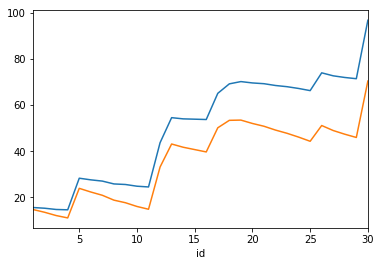

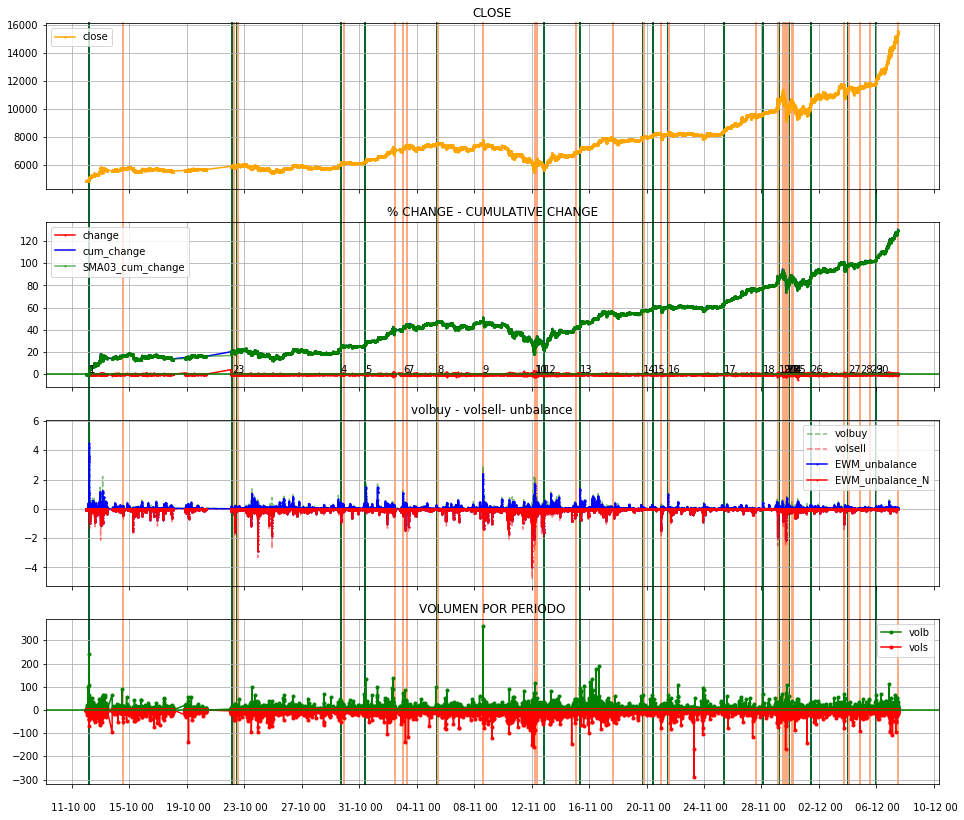

In [11]:
plotProfit()
plotHistory(plotVolume= True, plotTrades=True)

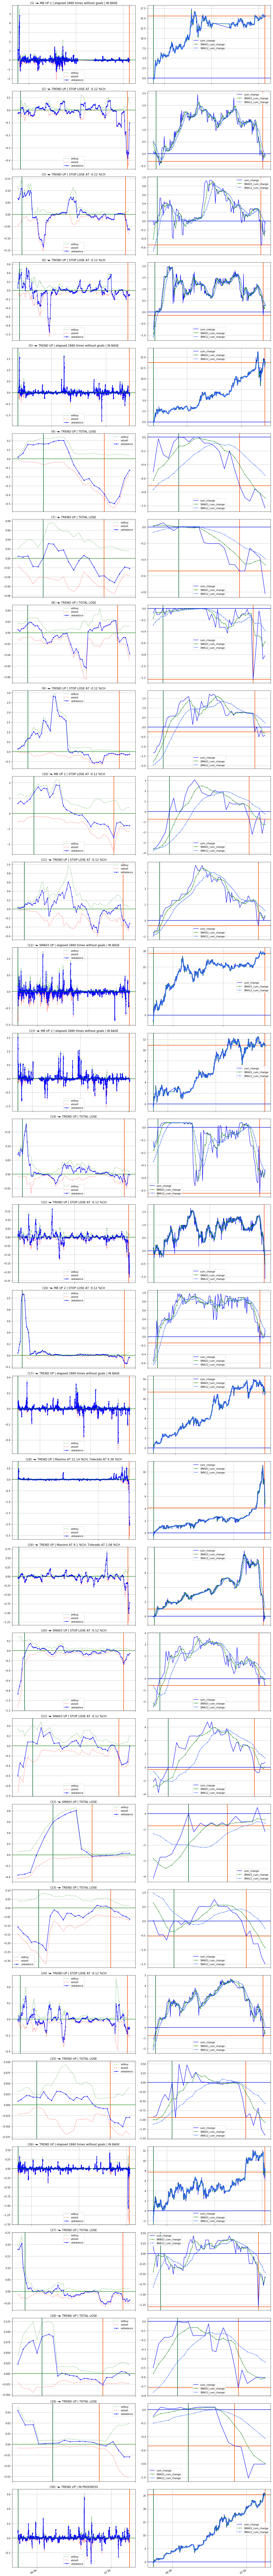

,openTime,closeTime,tradeDescription,OpeningTypeID,ClosingTypeID,openingCH,baseCH,targetCH,stopLoseCH,TotalLoseCH,...,deltaCH,openingP,baseP,targetP,stopLoseP,TotalLoseP,closingP,deltaP,Profit,Profit_Gastos
id,,,,,,,,,,,,,,,,,,,,,
1,2017-10-12 04:24:26.189361,2017-10-14 13:16:28.955507,(1) ─► MB UP 2 | elapsed 2880 times without go...,2,3,1.217471,2.097471,22.097471,1.097471,0.717471,...,15.543815,5128.339535,5173.468923,6199.136830,5122.185527,5153.981233,5759.850000,631.510465,15.543815,14.663815
2,2017-10-22 03:13:45.327318,2017-10-22 07:05:26.745735,(2) ─► TREND UP | STOP LOSE AT -0.12 %CH,6,2,19.555289,20.435289,40.435289,19.435289,19.055289,...,-0.307452,5848.354167,5899.819683,7069.490517,5841.336142,5877.595937,5829.983333,-18.370833,15.236363,13.476363
3,2017-10-22 11:42:07.280892,2017-10-22 13:46:26.090417,(3) ─► TREND UP | STOP LOSE AT -0.12 %CH,6,2,21.984751,22.864751,42.864751,21.864751,21.484751,...,-0.542754,5984.446512,6037.109641,7233.998943,5977.265176,6014.368744,5975.893333,-8.553178,14.693609,12.053609
4,2017-10-29 16:47:58.552211,2017-10-29 22:08:36.989587,(4) ─► TREND UP | STOP LOSE AT -0.12 %CH,6,2,24.474615,25.354615,45.354615,24.354615,23.974615,...,-0.145490,6075.476364,6128.940556,7344.035828,6068.185792,6105.853745,6083.353571,7.877208,14.548118,11.028118
5,2017-10-31 10:19:00.711604,2017-11-02 11:20:51.220069,(5) ─► TREND UP | elapsed 2880 times without g...,6,3,26.750873,27.630873,47.630873,26.630873,26.250873,...,13.723083,6212.756250,6267.428505,7509.979755,6205.300943,6243.820031,7073.266667,860.510417,28.271201,23.871201
6,2017-11-03 01:23:19.551393,2017-11-03 01:35:20.422625,(6) ─► TREND UP | TOTAL LOSE,6,4,43.305525,44.185525,64.185525,43.185525,42.805525,...,-0.710353,7270.766667,7334.749413,8788.902747,7262.041747,7307.120500,7224.581081,-46.185586,27.560848,22.280848
7,2017-11-03 07:47:58.947409,2017-11-03 08:00:04.280891,(7) ─► TREND UP | TOTAL LOSE,6,4,45.507840,46.387840,66.387840,45.387840,45.007840,...,-0.541780,7436.930769,7502.375760,8989.761914,7428.006452,7474.115423,7400.382353,-36.548416,27.019068,20.859068
8,2017-11-05 10:41:04.739275,2017-11-05 11:26:53.256482,(8) ─► TREND UP | TOTAL LOSE,6,4,47.873055,48.753055,68.753055,47.753055,47.373055,...,-1.232058,7574.700000,7641.357360,9156.297360,7565.610360,7612.573500,7521.382353,-53.317647,25.787010,18.747010
9,2017-11-08 14:21:10.266576,2017-11-08 15:11:07.869003,(9) ─► TREND UP | STOP LOSE AT -0.12 %CH,6,2,49.663935,50.543935,70.543935,49.543935,49.163935,...,-0.243294,7631.564103,7698.721867,9225.034687,7622.406226,7669.721923,7628.519403,-3.044700,25.543716,17.623716


In [12]:
plotAllTrades()
myTrades

In [13]:
deltaVol = tradesCondensation['volb'].sum() + tradesCondensation['vols'].sum()
deltaVol

-6489.0871949799912

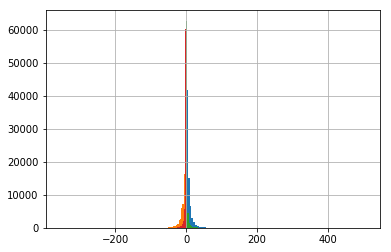

In [14]:
tradesCondensation['countb'].hist(bins=100)
tradesCondensation['counts'].hist(bins=100)
tradesCondensation['volb'].hist(bins=100)
tradesCondensation['vols'].hist(bins=100)

In [15]:
done = time.time()
elapsed = (done - start)/60
print(elapsed)

2.0426668326059976


In [16]:
"""
tradesHistory = pd.read_sql(dbTradesHistoryTable, con=engine)
tradesHistory.set_index(pd.DatetimeIndex(tradesHistory['time']),inplace=True)
tradesHistory.head()
tradesHistory.tail(10)
print(tradesCondensation['volb'].last_valid_index())
# limpiar datros corrompidos 
import sqlite3
conn = sqlite3.connect('krakenTeader.db')
c = conn.cursor()
#mydata = c.execute("DELETE FROM TradesCondensation WHERE time=?", ("2102-05-08 07:47:11.736900",))
mydata = c.execute("DELETE FROM TradesCondensation")
conn.commit()
c.close """

'\ntradesHistory = pd.read_sql(dbTradesHistoryTable, con=engine)\ntradesHistory.set_index(pd.DatetimeIndex(tradesHistory[\'time\']),inplace=True)\ntradesHistory.head()\ntradesHistory.tail(10)\nprint(tradesCondensation[\'volb\'].last_valid_index())\n# limpiar datros corrompidos \nimport sqlite3\nconn = sqlite3.connect(\'krakenTeader.db\')\nc = conn.cursor()\n#mydata = c.execute("DELETE FROM TradesCondensation WHERE time=?", ("2102-05-08 07:47:11.736900",))\nmydata = c.execute("DELETE FROM TradesCondensation")\nconn.commit()\nc.close '

In [17]:
import logging

logging.basicConfig(filename="LogEventos.log", level=logging.DEBUG)